# Example 0

---
#### This notebook will go over a few of the basics of generating new physics events with DarkNews.

Table of Contents:

1) **Generation**
    * generating events with the GenLauncher class
    * generating events on the command line

2) **Output**
    * Main Pandas Dataframe
    * Other formats printed to file
        * loading pickled and parquet pandas dataframes
        * loading numpy arrays with event information
        * hepevt and hepmc3 printing (**Under development!**)

3) **Inputs**
    * Experiments
    * Model parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

import DarkNews as dn

## 1) Generation

Let us start by generating neutrino upscattering events using GenLauncher and then using the command line.

### `GenLauncher` class

It is possible to run the generator through an instance of the `GenLauncher` class in the `DarkNews.GenLauncher` module.
We create an instance of this class, specifying the parameters of the run, then we use the `run()` method on this instance.
The created dataset can be found in the `data/` directory tree.
Alternatively, it an be accessed via the `df` attribute.

When using `GenLauncher`, the `run()` method accepts parameters as `log`, `verbose` or `logfile` (which can be also specified during the construction of the object).

As an example, we start by considering a 3+1 model with a heavy Z'. In this case, the HNL decays are 3-body ones. In short, we compute

$$ \nu_\mu A \to (N_4 \to \nu e^+e^-) A $$ 

where $\nu$ are all final state light neutrinos.


In [36]:
from DarkNews import GenLauncher

gen_object = GenLauncher(mzprime=1.25, m4=0.140, neval=1000, nu_flavors=['nu_mu'], noHF=True, HNLtype="majorana", loglevel="INFO")
df_1 = gen_object.run()

Initializing the three-portal model.
---------------------------------------------------------
   ______           _        _   _                     
   |  _  \         | |      | \ | |                    
   | | | |__ _ _ __| | __   |  \| | _____      _____   
   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  
   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  
   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  

---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes

Directory tree for this run already exists. Overriding it.
---------------------------------------------------------
Generating Events using the neutrino-nucleus upscattering engine

nu(mu) C12 --> N4  C12 --> nu_light e+ e- C12

---
We may consider another example, a 3+2 model with a light Z', and compute

$$ \nu_\mu A \to N_5 A \to N_4 Z^\prime A \to N_4 e^+e^- A $$ 

neglecting upscattering to $N_4$. In this case, the HNL decays are 2-body decays. By simply passing a value for the N5 mass, DarkNews already knows to use a 3+2 model, however, by default, all N6 mixing elements are set to zero, so it is important to specify these when using 3 HNLs.

In [44]:
%%prun -r

gen_object = GenLauncher(mzprime=1.25, m4=0.140, neval=1000, nu_flavors=['nu_mu','nu_mu_bar'], noHF=True, HNLtype="dirac", loglevel="ERROR")
df_1_dir = gen_object.run()

         1754102 function calls (1709450 primitive calls) in 2.726 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.326    0.054    1.896    0.316 MC.py:415(run_vegas)
      204    0.146    0.001    0.152    0.001 amplitudes.py:147(Lmunu_Hmunu_NC_SQR)
      204    0.128    0.001    0.135    0.001 amplitudes.py:154(Lmunu_Hmunu_KinMix_NC_inter)
        6    0.082    0.014    2.434    0.406 MC.py:177(get_MC_events)
      204    0.064    0.000    0.064    0.000 amplitudes.py:166(Lmunu_Hmunu_TMM_SQR)
    10164    0.057    0.000    0.143    0.000 core.py:2972(__array_finalize__)
    10476    0.054    0.000    0.054    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     2040    0.053    0.000    0.183    0.000 core.py:1150(__call__)
    15684    0.049    0.000    0.076    0.000 core.py:2946(_update_from)
27965/19808    0.046    0.000    0.189    0.000 {built-in method numpy.core._multiarray_umath.implement_array_fu

In [45]:
df_1_dir['w_decay_rate_0'].sum()/df_1['w_decay_rate_0'].sum()

1.0001202812561192

In [24]:
from particle import literals as lp

gen_object = GenLauncher(mzprime=1.25, m4=0.140, neval=10000, nu_flavors=['nu_mu','nu_mu_bar'], noHF=True, HNLtype="dirac", loglevel="error")

# ups_case = dn.processes.UpscatteringProcess(nu_projectile=dn.pdg.numu, 
#                                             nu_upscattered=dn.pdg.neutrino4,
#                                             nuclear_target=dn.detector.NuclearTarget("C12"),
#                                             scattering_regime='coherent',
#                                             helicity='conserving',
#                                             TheoryModel=gen_object.bsm_model)

decay_case = dn.processes.FermionDileptonDecay(nu_parent=dn.pdg.neutrino4,
                                                nu_daughter=dn.pdg.nulight,
                                                final_lepton1 = lp.e_plus, 
                                                final_lepton2 = lp.e_minus,
                                                h_parent = +1,
                                                TheoryModel=gen_object.bsm_model)


PS = 0.00635962,0.00128319,0.01195772,-0.99800031,2.78133927

dn.decay_rates.diff_gamma_Ni_to_Nj_ell_ell(PS, decay_case)

Initializing the three-portal model.


1.43258541314869e-21

In [30]:
%%prun -r 

for i in range(5000):
    dn.decay_rates.diff_gamma_Ni_to_Nj_ell_ell(PS, decay_case)

         60003 function calls in 0.266 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     5000    0.102    0.000    0.256    0.000 decay_rates.py:273(diff_gamma_Ni_to_Nj_ell_ell)
     5000    0.029    0.000    0.029    0.000 decay_rates.py:355(Amp_TMM_SQR)
     5000    0.028    0.000    0.028    0.000 decay_rates.py:349(Amp_KinMix_NC_inter)
     5000    0.027    0.000    0.027    0.000 decay_rates.py:343(Amp_NC_SQR)
     5000    0.025    0.000    0.025    0.000 decay_rates.py:346(Amp_KinMix_SQR)
     5000    0.016    0.000    0.016    0.000 decay_rates.py:334(Amp_CC_NC_inter)
     5000    0.014    0.000    0.014    0.000 decay_rates.py:337(Amp_CC_KinMix_inter)
        1    0.011    0.011    0.266    0.266 <string>:1(<module>)
     5000    0.007    0.000    0.007    0.000 decay_rates.py:331(Amp_CC_SQR)
    10000    0.005    0.000    0.005    0.000 decay_rates.py:24(lam)
     5000    0.001    0.000    0.001    0.000 {method

In [27]:
  ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     5000    1.749    0.000    2.432    0.000 decay_rates.py:273(diff_gamma_Ni_to_Nj_ell_ell)
   645000    0.676    0.000    0.676    0.000 const.py:285(<lambda>)
        1    0.016    0.016    2.448    2.448 <string>:1(<module>)
    10000    0.007    0.000    0.007    0.000 decay_rates.py:24(lam)
        1    0.000    0.000    2.448    2.448 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [4]:
gen_object_2 = GenLauncher(Umu5=1e-3, UD5=1/np.sqrt(2), chi=0.0031, gD=2, mzprime=0.03, m4=0.080, m5=0.140, neval=1000, HNLtype="dirac")
df_2 = gen_object_2.run(loglevel="INFO")

Initializing the three-portal model.
---------------------------------------------------------
   ______           _        _   _                     
   |  _  \         | |      | \ | |                    
   | | | |__ _ _ __| | __   |  \| | _____      _____   
   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  
   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  
   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  

---------------------------------------------------------
Model:
	2 dirac heavy neutrino(s).

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes

Directory tree for this run already exists. Overriding it.
---------------------------------------------------------
Generating Events using the neutrino-nucleus upscattering engine

nu(mu) C12 --> N5  C12 --> N4 e+ e- C12
Helicity

---
<span style="color: orange;">

Finally, let's try setting some model-independent interaction vertices.

In [8]:
# kwargs = {'d_mu5': 1e-4, 'd_45': 0.1, 'deV': 1e-3, 'deA': 1e-3, 'duV': 2e-3, 'ddV': 1e-3}
kwargs = {'d_mu5': 1e-4, 'd_45': 0.1, 'deV': 1e-3, 'deA': 1e-3, 'dprotonV': 1e-3}
gen_object_3 = dn.GenLauncher(mzprime=0.03, m4=0.080, m5=0.140, neval=1000, HNLtype="dirac", **kwargs)
df_3 = gen_object_3.run(loglevel="INFO")

Initializing a generic model.
---------------------------------------------------------
   ______           _        _   _                     
   |  _  \         | |      | \ | |                    
   | | | |__ _ _ __| | __   |  \| | _____      _____   
   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  
   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  
   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  

---------------------------------------------------------
Model:
	2 dirac heavy neutrino(s).

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes

Directory tree for this run already exists. Overriding it.
---------------------------------------------------------
Generating Events using the neutrino-nucleus upscattering engine

nu(mu) C12 --> N5  C12 --> N4 e+ e- C12
Helicity conser

---
### `dn_gen` command line functionality

It is also possible to run the generator in the command line via the `dn_gen` script passing the parameters as arguments.
The created dataset can be found in the `data/` directory tree, which is created in the same folder the script is run.

Let's try to run another example. We are running this from the jupyter notebook, but you may as well run it from your own command line.


In [5]:
cmd_string = "dn_gen --mzprime=0.03 --m4=0.140 --alpha_epsilon2=2e-10 --Umu4=1e-4 --UD4=1 --alphaD=0.25 --neval=1000 --HNLtype=dirac --loglevel=WARNING --hepevt --numpy --pandas --parquet"
_=os.system(cmd_string)

sh: dn_gen: command not found


---
# 2) Output format

### Pandas DataFrame Output

Let's start by looking at the main DarkNews dataframe returned by `GenLancher`

Our main object is a `MultiIndex dataframe`, with:
* rows corresponding to individual events 

    * Each event contains the components for all the 4-momenta of the particles involved:
$$\nu _\text{P\_projectile} + \text{Hadronic target} _\text{P\_target} \to N _\text{P\_decay\_N\_parent} + \text{Hadronic recoil} _\text{P\_recoil}$$


* Columns are properties, including four momenta, event rate weights, event scattering regime, scattering and decay positions, scattering target, etc.
* Subcolumns correspond to Lorentz indices for four momenta and position 4-vectors.
* metadata information inside `df.attrs`

| **Column**            | **Subcolumn** |**type**  | **description**|
|:--------------------------|:--------:|:--------:|:-----------------------------------|
| **P\_projectile**         | **0**    | `float`  | 4-momenta of beam neutrino |
| <!-- -->                  | **1**    | `float`  | <!-- --> |
| <!-- -->                  | **2**    | `float`  | <!-- --> |
| <!-- -->                  | **3**    | `float`  | <!-- --> |
| **P\_decay\_N\_parent**   | **0**    | `float`  | 4-momenta of HNL\_parent |
| <!-- -->                  | **1**    | `float`  | <!-- --> |
| <!-- -->                  | **2**    | `float`  | <!-- --> |
| <!-- -->                  | **3**    | `float`  | <!-- --> |
| **P\_target**             | **0**    | `float`  | 4-momenta of nucleus |
| <!-- -->                  | **1**    | `float`  | <!-- --> |
| <!-- -->                  | **2**    | `float`  | <!-- --> |
| <!-- -->                  | **3**    | `float`  | <!-- --> |
| **P\_recoil**             | **0**    | `float`  | 4-momenta of recoiled nucleus |
| <!-- -->                  | **1**    | `float`  | <!-- --> |
| <!-- -->                  | **2**    | `float`  | <!-- --> |
| <!-- -->                  | **3**    | `float`  | <!-- --> |
| **P\_decay\_ell\_minus**  | **0**    | `float`  | 4-momenta of e- |
| <!-- -->                  | **1**    | `float`  | <!-- --> |
| <!-- -->                  | **2**    | `float`  | <!-- --> |
| <!-- -->                  | **3**    | `float`  | <!-- --> |
| **P\_decay\_ell\_plus**   | **0**    | `float`  | 4-momenta of e+ |
| <!-- -->                  | **1**    | `float`  | <!-- --> |
| <!-- -->                  | **2**    | `float`  | <!-- --> |
| <!-- -->                  | **3**    | `float`  | <!-- --> |
| **P\_decay\_N\_daughter** | **0**    | `float`  | 4-momenta of HNL\_daughter / nu\_daughter |
| <!-- -->                  | **1**    | `float`  | <!-- --> |
| <!-- -->                  | **2**    | `float`  | <!-- --> |
| <!-- -->                  | **3**    | `float`  | <!-- --> |
| **pos_scatt**   | **0**    | `float`  | upscattering position|
| <!-- -->                  | **1**    | `float`  | <!-- --> |
| <!-- -->                  | **2**    | `float`  | <!-- --> |
| <!-- -->                  | **3**    | `float`  | <!-- --> |
| **pos_decay**   | **0**    | `float`  | decay position of primary particle (N\_parent) -- no secondary decay position is saved. |
| <!-- -->                  | **1**    | `float`  | <!-- --> |
| <!-- -->                  | **2**    | `float`  | <!-- --> |
| <!-- -->                  | **3**    | `float`  | <!-- --> |
| **w\_decay\_rate\_0**     | <!-- --> | `float`  | Weight of the decay rate of primary unstable particle: &Sigma;<sub>i</sub> w<sub>i</sub> = &Gamma;<sub>N</sub> |
| **w\_decay\_rate\_1**     | <!-- --> | `float`  | Weight of the decay rate of secondary unstable particle: &Sigma;<sub>i</sub> w<sub>i</sub> = &Gamma;<sub>X</sub> |
| **w\_event\_rate**        | <!-- --> | `float`  | Weight for the event rate: &Sigma;<sub>i</sub> w<sub>i</sub> = event rate |
| **w\_flux\_avg\_xsec**    | <!-- --> | `float`  | Weight of the flux averaged cross section: &Sigma;<sub>i</sub> w<sub>i</sub> = int(sigma &sdot; flux) &sdot; exposure |
| **target**                | <!-- --> | *string*   | Name of object, it will typically be a nucleus, some free proton, or a bound nucleon |
| **target\_pdgid**         | <!-- --> | `int`    | PDG id of the target |
| **scattering\_regime**    | <!-- --> | *string* | Regime can be coherent or p-el or n-el |
| **helicity**              | <!-- --> | *string* | Helicity process: can be flipping or conserving |
| **underlying\_process**   | <!-- --> | *string* | String of the underlying process, e.g, "nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu(mu) + e+ + e- + proton_in_C12" |


In [5]:
print(*df_1,2*'\n')

('P_projectile', '0') ('P_projectile', '1') ('P_projectile', '2') ('P_projectile', '3') ('P_target', '0') ('P_target', '1') ('P_target', '2') ('P_target', '3') ('P_recoil', '0') ('P_recoil', '1') ('P_recoil', '2') ('P_recoil', '3') ('P_decay_N_parent', '0') ('P_decay_N_parent', '1') ('P_decay_N_parent', '2') ('P_decay_N_parent', '3') ('P_decay_ell_minus', '0') ('P_decay_ell_minus', '1') ('P_decay_ell_minus', '2') ('P_decay_ell_minus', '3') ('P_decay_ell_plus', '0') ('P_decay_ell_plus', '1') ('P_decay_ell_plus', '2') ('P_decay_ell_plus', '3') ('P_decay_N_daughter', '0') ('P_decay_N_daughter', '1') ('P_decay_N_daughter', '2') ('P_decay_N_daughter', '3') ('pos_scatt', '0') ('pos_scatt', '1') ('pos_scatt', '2') ('pos_scatt', '3') ('w_decay_rate_0', '') ('w_event_rate', '') ('w_flux_avg_xsec', '') ('target', '') ('target_pdgid', '') ('scattering_regime', '') ('helicity', '') ('underlying_process', '') ('pos_decay', '0') ('pos_decay', '1') ('pos_decay', '2') ('pos_decay', '3') 




---
### Metadata

In addition to the information about the events, the pickled or GenLauncher-returned pandas dataframe contains metadata on the model, experiment, and data path properties, all stored in [df.attrs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.attrs.html). We have:

1. **experiment**: this is a class DarkNews.experiment.Detector, which contains all the information about the experiment for which the events are generated. It also contains a list of instances of the NuclearTarget class, which contains information about the different scattering targets used.


In [7]:
keys = list(df_1.attrs['experiment'].__dict__.keys())
print(f"Attributes of Detector class: \n", *keys)
print(f"\nAttributes of NuclearTarget class: \n", *list(df_1.attrs['experiment'].NUCLEAR_TARGETS[0].__dict__))

KeyError: 'experiment'

Now we look at how to obtain the nuclear targets used by the DarkNews generator

In [9]:
fid_mass = df_1.attrs['experiment'].FIDUCIAL_MASS_PER_TARGET
for target, fid_mass in zip(df_1.attrs['experiment'].NUCLEAR_TARGETS, df_1.attrs['experiment'].FIDUCIAL_MASS_PER_TARGET):
    print(f"{fid_mass:.2f} tonnes of {target.name}")

701.14 tonnes of C12
116.86 tonnes of H1


---
2. **model**: this attribute contains DarkNews.model.Model, which stores all the new physics parameters used in the generation. This includes both low-level information, such as the couplings, say $g_D$, as well as high-level ones, such as the couplings of the $Z^\prime$ to electrons, $d_e^V$ and $d_e^A$.

In [15]:
df_1.attrs.keys()

dict_keys(['experiment', 'model', 'data_path'])

In [10]:
print("Some low-level parameters:\n", *list(df_1.attrs['model'].__dict__.keys())[:19],' ...')
print("\nSome high-level parameters:\n", *list(df_1.attrs['model'].__dict__.keys())[-14:],' ...')

Some low-level parameters:
 model_file name m4 m5 m6 mzprime mhprime s_e4 s_e5 s_e6 s_mu4 s_mu5 s_mu6 s_tau4 s_tau5 s_tau6 s_44 s_45 s_46  ...

Some high-level parameters:
 fs fN_higgs c_nucleon_higgs cSnucleon dprotonS dneutronS ceS deS is_mass_mixed has_Zboson_coupling has_vector_coupling zprime has_scalar_coupling has_TMM  ...


---
### Other output formats

Let's now look at some other formats printed to file.

In [14]:
path_to_data = Path('./data/miniboone_fhc/3plus1/m4_0.14_mzprime_0.03_dirac/')

# pickled pandas dataframe 
df_p = pd.read_pickle(path_to_data/'pandas_df.pckl')

# pandas dataframe from parquet
df_p_pq = pd.read_parquet(path_to_data/'pandas_df.parquet')

# numpy ndarray
nd_a = np.load(path_to_data/'ndarray.npy')

# HEPEVT -- CURRENTLY UNDER DEVELOPMENT
import pyhepmc_ng as hep
hepevt_file = hep.ReaderHEPEVT(str(path_to_data/'HEPevt.dat'))
evt = hepevt_file.read_event

Text(0.5, 0, '$E_\\nu/$GeV')

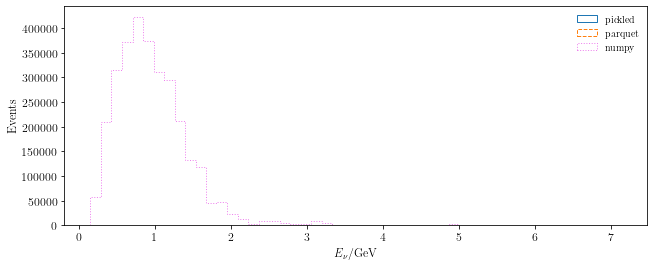

In [15]:
# and now histogram neutrino energy as an example
fig, ax = dn.plot_tools.std_fig(figsize=(10,4))

_=ax.hist(df_p['P_projectile','0'], weights=df_p['w_event_rate',''], bins=50, histtype='step', label='pickled')
_=ax.hist(df_p_pq['P_projectile','0'], weights=df_p_pq['w_event_rate',''], bins=50, ls='--', histtype='step', label='parquet')
_=ax.hist(nd_a[:,0], weights=nd_a[:,-8], bins=50, ls=':', color='violet', histtype='step', label='numpy')

ax.legend()
ax.set_ylabel('Events')
ax.set_xlabel(r'$E_\nu/$GeV')

Text(0.5, 0, '$\\Delta \\theta_{ee}$ (degrees)')

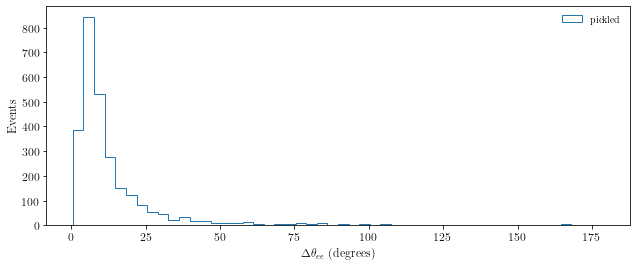

In [16]:
# Let's compute something more interesting: opening angle of e+e-

mee = np.arccos(dn.fourvec.df_cos_opening_angle(df_p['P_decay_ell_minus'],df_p['P_decay_ell_plus']))*dn.const.rad_to_deg

fig, ax = dn.plot_tools.std_fig(figsize=(10,4))

_=ax.hist(mee, weights=df_p['w_event_rate',''], bins=50, histtype='step', label='pickled')

ax.legend()
ax.set_ylabel('Events')
ax.set_xlabel(r'$\Delta \theta_{ee}$ (degrees)')

---
# 3) Inputs


### Experiments
It is possible to select an experiment through the `exp` argument of the `GenLauncher` class (or `--exp` option of the command line interface):
1. specifying a keyword for a pre-defined experiment among:
    * DUNE FHC ND (`"dune_nd_fhc"`)
    * DUNE RHC ND (`"dune_nd_rhc"`)
    * MicroBooNE (`"microboone"`)
    * MINERVA FHC LE (`"minerva_le_fhc"`)
    * MINERVA FHC ME (`"minerva_me_fhc"`)
    * MINERVA RHC ME (`"minerva_me_rhc"`)
    * MiniBooNE FHC (`"miniboone_fhc"`)
    * MINOS FHC LE (`"minos_le_fhc"`)
    * MINOS FHC ME (`"minos_me_fhc"`)
    * ND280 FHC (`"nd280_fhc"`)
    * NOvA FHC (`"nova_le_fhc"`)
    * NuTeV FHC (`"nutev_fhc"`)
    * FASERv (`"fasernu"`)

2. specifying the file path of an experiment file: every file should be specified using the same rules as for the parameters file.
A template file [`template_custom_experiment.txt`](examples/template_custom_experiment.txt) can be found in this directory.

In [17]:
list_of_experiments = [
'dune_nd_fhc',
'dune_nd_rhc',
'microboone',
'minerva_le_fhc',
'minerva_me_fhc',
'minerva_me_rhc',
'miniboone_fhc',
'minos_le_fhc',
'minos_me_fhc',
'nd280_fhc',
'nova_le_fhc',
'nutev_fhc',
'fasernu']

rates = []
for exp in list_of_experiments:
    # use default model 
    gen_object = GenLauncher(exp=exp, neval=100, loglevel='ERROR')
    df=gen_object.run()
    rates.append(sum(df.w_event_rate))

Initializing a three-portal model.


FileNotFoundError: [Errno 2] No such file or directory: '/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/include/detectors/minos_me_fhc.txt'

---
Now we print the total rate in each expriment. 

Note that these numbers don't mean anything without an appropriate definition of signal selection and fiducial volume. 

Exposures and target masses do not necessarily represent the official ones used by collaborations, nor are they optimized for this signature.

In [ ]:
for exp,rate in zip(list_of_experiments,rates):
    print(f'{exp}: {rate:.2g}')

dune_nd_fhc: 9.4e+05
dune_nd_rhc: 7.8e+04
microboone: 1.7e+03
minerva_le_fhc: 2e+03
minerva_me_fhc: 1.6e+04
minerva_me_rhc: 1.6e+04
miniboone_fhc: 2e+04
minos_le_fhc: 2.8e+04
minos_me_fhc: 6.7e+04
nd280_fhc: 2.1e+03
nova_le_fhc: 9.5e+04
nutev_fhc: 1.4e+03
fasernu: 3.2


---
### Custom Experiment files

And now we can input our own user-defined experimental files.

In [157]:
cmd_string = "dn_gen --exp=./template_custom_experiment.txt --loglevel=ERROR"
_=os.system(cmd_string)

In [158]:
gen_object = GenLauncher(exp="./template_custom_experiment.txt", loglevel='ERROR')
_=gen_object.run()

---
### Model files

It is possible to specify model parameters through a file.
This can be done either via the command-line interface, thorugh the option `--param-file` or via the `GenLauncher` class, thorugh the argument `param-file` in the constructor.
In any case, the parameters specified in the file will overwrite the default ones, but will be overwritten by any other definition (either via options in command-line mode or via the keyword arguments in the `GenLauncher` constructor) of the same variable.

A template file [`template_parameters_file.txt`](examples/template_parameters_file.txt) can be found in this directory.
The file interface allows the user to specify the parameters with far more freedom, enabling the possibility to use mathematical expressions, involving user-defined constants, while keeping all the parameters in one single file.

In [159]:
cmd_string = "dn_gen --param-file=./parameters_example_1.txt --loglevel=ERROR"
_=os.system(cmd_string)

In [160]:
gen_object = GenLauncher(param_file="./parameters_example_1.txt", loglevel='ERROR')
df_1 = gen_object.run()

In [161]:
cmd_string = "dn_gen --param-file=./parameters_example_2.txt --loglevel=ERROR"
_=os.system(cmd_string)

In [162]:
gen_object = GenLauncher(param_file="./parameters_example_2.txt", loglevel='ERROR')
df_2=gen_object.run()